In [1]:
library(dplyr)
library(ggplot2)


ZOTU_phylum <- read.csv("phylum_ZOTUs.csv")

relative_abundance_all <- read.csv("relative_abundance_with_age.csv")
relative_abundance_with_age <- relative_abundance_all %>% select(-Melatonin_pg_g_Stool)
relative_abundance <- relative_abundance_with_age %>% select(-age_group)
relative_abundance_corr <- relative_abundance %>% select(-Sample_Code_16s)


max_top_zotus <- 5700
all_zotus<- dim(relative_abundance)[2]
#defaults
zotu_pos <-0
zotu_neg <-0
all_samples <- dim(relative_abundance)[1]


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
# Calculate mean abundance for each OTU across all samples
mean_abundance <- colMeans(relative_abundance_corr)

# Sort OTUs by mean abundance in descending order and select the top 50 OTUs
top_otus <- sort(mean_abundance, decreasing = TRUE)[1:max_top_zotus]



In [3]:
relative_abundance_new <- relative_abundance_all[, c("Sample_Code_16s", "age_group", "Melatonin_pg_g_Stool")]
# Subset the original data to only include the top 50 OTUs
top_otu_data <- relative_abundance_corr %>%
  select(names(top_otus))

In [4]:
relative_abundance_new <- cbind(relative_abundance_new, top_otu_data)


`summarise()` has grouped output by 'age_group'. You can override using the `.groups` argument.


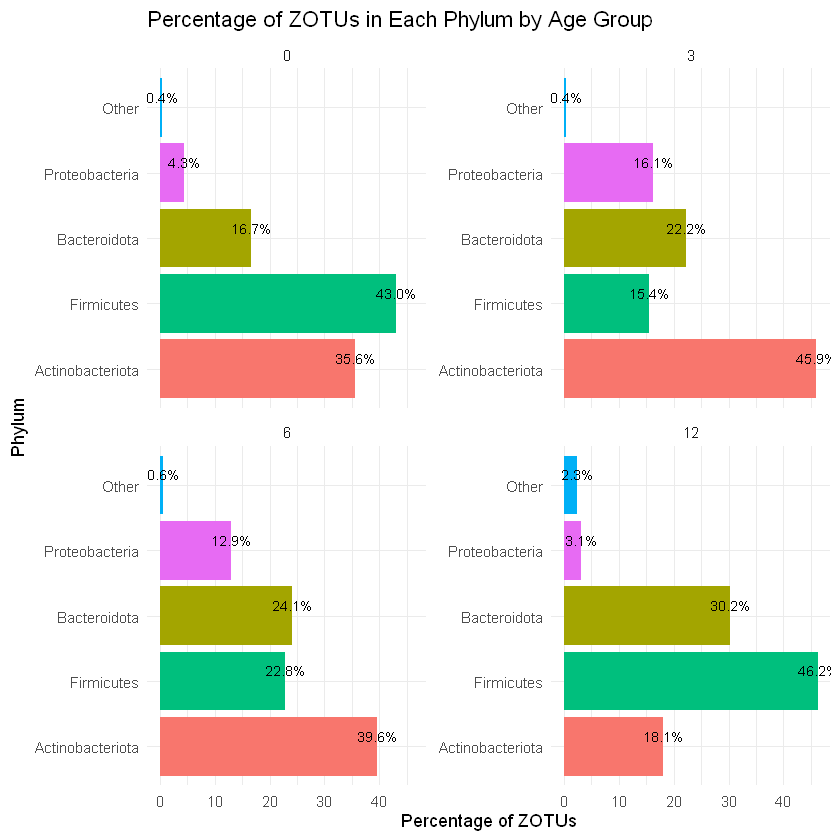

In [5]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(ggplot2)

# Assuming relative_abundance_with_age and ZOTU_phylum are your data frames

# Melt the relative abundance data into a long format for easier analysis
relative_long <- relative_abundance_new %>%
  pivot_longer(cols = starts_with("ZOTU"), names_to = "OTU_ID", values_to = "Abundance")

# Merge with ZOTU_phylum to get the phylum information
merged_data <- merge(relative_long, ZOTU_phylum, by = "OTU_ID")

# Group by age group and phylum, then summarize the ZOTU counts per phylum
phylum_summary_by_age <- merged_data %>%
  group_by(age_group, Phylum) %>%
  summarise(Total_Abundance = sum(Abundance)) %>%
  mutate(Percent = (Total_Abundance / sum(Total_Abundance)) * 100)

# Select the top 4 most common phyla per age group and group the rest into "Other"
top_phyla_by_age <- phylum_summary_by_age %>%
  group_by(age_group) %>%
  arrange(desc(Total_Abundance)) %>%
  slice(1:4)

# Combine the rest into "Other" for each age group
other_phyla_by_age <- phylum_summary_by_age %>%
  group_by(age_group) %>%
  arrange(desc(Total_Abundance)) %>%
  slice(5:n()) %>%
  summarise(Phylum = "Other", Total_Abundance = sum(Total_Abundance), Percent = sum(Percent))

# Combine top phyla and "Other"
final_phylum_summary_by_age <- bind_rows(top_phyla_by_age, other_phyla_by_age)

# Plot the percentage of ZOTUs in each phylum by age group and add percentage labels
ggplot(final_phylum_summary_by_age, aes(x = reorder(Phylum, -Percent), y = Percent, fill = Phylum)) +
  geom_bar(stat = "identity") +
  geom_text(aes(label = sprintf("%.1f%%", Percent)), vjust = -0.5, size = 3) +  # Add percentage labels
  facet_wrap(~age_group, scales = "free_y") +  # Create separate plots for each age group
  coord_flip() +  # Flip the coordinates for better readability
  labs(title = "Percentage of ZOTUs in Each Phylum by Age Group",
       x = "Phylum",
       y = "Percentage of ZOTUs") +
  theme_minimal() +
  theme(legend.position = "none")


In [6]:
calculate_zotu_melatonin_correlation <- function(relative_abundance_new) {
  # Extract the ZOTU columns (assuming columns start with "ZOTU")
  zotu_columns <- grep("^ZOTU", colnames(relative_abundance_new), value = TRUE)
  
  # Create a function to calculate correlation for each ZOTU with Melatonin
  correlation_results <- lapply(zotu_columns, function(zotu) {
    cor_test <- cor.test(relative_abundance_new[[zotu]], relative_abundance_new$Melatonin_pg_g_Stool, method = "pearson")
    data.frame(ZOTU = zotu,
               Correlation = cor_test$estimate,
               P_Value = cor_test$p.value)
  })
  
  # Combine the results into a single data frame
  correlation_summary <- do.call(rbind, correlation_results)
  
  # Return the correlation summary
  return(correlation_summary)
}


extract_significant_zotus <- function(correlation_summary, ZOTU_phylum) {
  # Remove NAs from the correlation summary
  correlation_summary <- na.omit(correlation_summary)
  
  # Identify ZOTUs with significant positive correlations
  ZOTU_corr_sign_pos <- correlation_summary[correlation_summary$P_Value < 0.05 & correlation_summary$Correlation > 0, ]$ZOTU
  
  # Filter ZOTU_phylum to include only ZOTUs in positive significance
  ZOTU_phylum_significance_pos <- ZOTU_phylum %>%
    filter(OTU_ID %in% ZOTU_corr_sign_pos)
  
  # Identify ZOTUs with significant negative correlations
  ZOTU_corr_sign_neg <- correlation_summary[correlation_summary$P_Value < 0.05 & correlation_summary$Correlation < 0, ]$ZOTU
  
  # Filter ZOTU_phylum to include only ZOTUs in negative significance
  ZOTU_phylum_significance_neg <- ZOTU_phylum %>%
    filter(OTU_ID %in% ZOTU_corr_sign_neg)
  
  # Count the number of ZOTUs in positive and negative significance
  zotu_pos <- nrow(ZOTU_phylum_significance_pos)
  zotu_neg <- nrow(ZOTU_phylum_significance_neg)
  
  # Return a list of results
  return(list(
    ZOTU_phylum_significance_pos = ZOTU_phylum_significance_pos,
    ZOTU_phylum_significance_neg = ZOTU_phylum_significance_neg,
    zotu_pos = zotu_pos,
    zotu_neg = zotu_neg
  ))
}


In [ ]:
# Split the dataset by age group
relative_abundance_new_3 <- relative_abundance_new[relative_abundance_new$age_group == 3, ]
relative_abundance_new_6 <- relative_abundance_new[relative_abundance_new$age_group == 6, ]
relative_abundance_new_12 <- relative_abundance_new[relative_abundance_new$age_group == 12, ]

# For age group 3 months
correlation_summary_3 <- calculate_zotu_melatonin_correlation(relative_abundance_new_3)
significant_zotus_3 <- extract_significant_zotus(correlation_summary_3, ZOTU_phylum)

# For age group 6 months
correlation_summary_6 <- calculate_zotu_melatonin_correlation(relative_abundance_new_6)
significant_zotus_6 <- extract_significant_zotus(correlation_summary_6, ZOTU_phylum)

# For age group 12 months
correlation_summary_12 <- calculate_zotu_melatonin_correlation(relative_abundance_new_12)
significant_zotus_12 <- extract_significant_zotus(correlation_summary_12, ZOTU_phylum)

# Access results for each age group
# Age 3 months
ZOTU_phylum_significance_pos_3 <- significant_zotus_3$ZOTU_phylum_significance_pos
ZOTU_phylum_significance_neg_3 <- significant_zotus_3$ZOTU_phylum_significance_neg
zotu_pos_3 <- significant_zotus_3$zotu_pos
zotu_neg_3 <- significant_zotus_3$zotu_neg

# Age 6 months
ZOTU_phylum_significance_pos_6 <- significant_zotus_6$ZOTU_phylum_significance_pos
ZOTU_phylum_significance_neg_6 <- significant_zotus_6$ZOTU_phylum_significance_neg
zotu_pos_6 <- significant_zotus_6$zotu_pos
zotu_neg_6 <- significant_zotus_6$zotu_neg

# Age 12 months
ZOTU_phylum_significance_pos_12 <- significant_zotus_12$ZOTU_phylum_significance_pos
ZOTU_phylum_significance_neg_12 <- significant_zotus_12$ZOTU_phylum_significance_neg
zotu_pos_12 <- significant_zotus_12$zotu_pos
zotu_neg_12 <- significant_zotus_12$zotu_neg

zotu_pos_all= zotu_pos_3 +zotu_pos_6 +zotu_pos_12
zotu_neg_all= zotu_neg_3 +zotu_neg_6 +zotu_neg_12


Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation is zero"
Warning message in cor(x, y):
"the standard deviation i

In [ ]:

# Define the four main phyla
main_phyla <- c("Actinobacteriota", "Firmicutes", "Bacteroidota", "Proteobacteria")

# Assign colors based on Phylum for consistency, including "Other"
phyla_colors <- c("Actinobacteriota" = "#1f77b4",  # Blue
                  "Firmicutes" = "#ff7f0e",        # Orange
                  "Bacteroidota" = "#2ca02c",      # Green
                  "Proteobacteria" = "#d62728",    # Red
                  "Other" = "#9467bd")             # Purple for Other

# Add age group labels to each dataset and combine them into one
ZOTU_phylum_significance_pos_3 <- ZOTU_phylum_significance_pos_3 %>%
  mutate(Age = paste0("3 (n = ", zotu_pos_3, ")"), Phylum = ifelse(Phylum %in% main_phyla, Phylum, "Other"))

ZOTU_phylum_significance_pos_6 <- ZOTU_phylum_significance_pos_6 %>%
  mutate(Age = paste0("6 (n = ", zotu_pos_6, ")"), Phylum = ifelse(Phylum %in% main_phyla, Phylum, "Other"))

ZOTU_phylum_significance_pos_12 <- ZOTU_phylum_significance_pos_12 %>%
  mutate(Age = paste0("12 (n = ", zotu_pos_12, ")"), Phylum = ifelse(Phylum %in% main_phyla, Phylum, "Other"))


In [ ]:
# Load required libraries
library(ggplot2)
library(dplyr)
library(tidyr)      # Replacing dcast for pivot_wider
library(scales)     # For muted colors
library(patchwork)  # For combining plots
library(viridis)    # For color palette
library(forcats)



In [ ]:
# Load necessary libraries
library(ggplot2)
library(dplyr)

# Define the main phyla for color assignment
phyla_colors <- c("Actinobacteriota" = "#1f77b4",  # Blue
                  "Firmicutes" = "#ff7f0e",        # Orange
                  "Bacteroidota" = "#2ca02c",      # Green
                  "Proteobacteria" = "#d62728",    # Red,
                  "Other" = "#9467bd")             # Purple (for Other if needed)

# Summarize data for 3 months
phylum_summary_3m <- ZOTU_phylum_significance_pos_3 %>%
  group_by(Phylum) %>%
  summarise(ZOTU_count = n()) %>%
  mutate(Age = "3 months", Percent = (ZOTU_count / sum(ZOTU_count)) * 100)

# Summarize data for 6 months
phylum_summary_6m <- ZOTU_phylum_significance_pos_6 %>%
  group_by(Phylum) %>%
  summarise(ZOTU_count = n()) %>%
  mutate(Age = "6 months", Percent = (ZOTU_count / sum(ZOTU_count)) * 100)

# Summarize data for 12 months
phylum_summary_12m <- ZOTU_phylum_significance_pos_12 %>%
  group_by(Phylum) %>%
  summarise(ZOTU_count = n()) %>%
  mutate(Age = "12 months", Percent = (ZOTU_count / sum(ZOTU_count)) * 100)

# Combine the summaries into one dataset
phylum_summary_all <- bind_rows(phylum_summary_3m, phylum_summary_6m, phylum_summary_12m)

# Ensure consistent phylum labels (if some are missing)
phylum_summary_all <- phylum_summary_all %>%
  mutate(Phylum = ifelse(Phylum %in% names(phyla_colors), Phylum, "Other"))

# Set the order of Age as a factor to ensure correct ordering on the x-axis
phylum_summary_all$Age <- factor(phylum_summary_all$Age, 
                                 levels = c("3 months", "6 months", "12 months"))
# Calculate sum counts of ZOTUs
phylum_summary_all <- phylum_summary_all %>%
  group_by(Age) %>%
  mutate(Sum_counts =  sum(ZOTU_count))

In [ ]:
# Create the stacked bar plot
bar_plot<- ggplot(phylum_summary_all, aes(
    x =  fct_reorder(paste0(Age, "\n n= ", Sum_counts), Sum_counts, .desc = TRUE), # Order x-axis

    y = Percent, fill = Phylum)) +
  geom_bar(stat = "identity", position = "stack", width = 0.6) +  # Stacked bar chart
  scale_fill_manual(values = phyla_colors) +  # Use the consistent color scheme
  geom_text(aes(label = paste0(round(Percent, 1), "%")), 
            position = position_stack(vjust = 0.2), 
            size = 3.5, color = "black") +  # Add percentage labels inside the bars
  labs(title = "Perc. ZOTUs in Phylum",
       x = "Age (Months)",
       y = "ZOTUs (%)",
       fill = "Phylum") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 12, hjust = 1, face = "bold"),  # Adjust ZOTU names for readability
        axis.text.x = element_text(angle = 45, hjust = 1, size = 12),  # Rotate x-axis labels for clarity
        legend.position = "right")  # Place the legend on the right for clarity

# Print the plot

print(bar_plot)

In [ ]:
# New row to add
new_row_other <- data.frame(
  Phylum = "Other",
  ZOTU_count = 0,
  Age = "3 months",
    Percent = 0,
    Sum_counts = 0
)

# Add the new row
phylum_summary_all <- rbind(phylum_summary_all,new_row_other)


In [ ]:
# Plot Heatmap
heatmap_plot <- ggplot(phylum_summary_all, aes(x = fct_reorder(Age,  Sum_counts, .desc=TRUE),
                                              y = fct_reorder(Phylum, ZOTU_count) , fill = ZOTU_count)) +
  geom_tile(color = "white") +
  geom_text(aes(label = ZOTU_count), color = "black", size = 3) +
  scale_fill_viridis(option = "plasma", name = "Count (ZOTUs)", direction = -1) +
  labs(title = "ZOTUs counts in each Phylum  Across Ages", x = "Age (Months)", y = "Phylum") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14),
    legend.position = "right"
  )
heatmap_plot

In [ ]:
 all_plots = heatmap_plot / bar_plot

In [ ]:
all_plots

In [ ]:
# Save the plot as an SVG file
ggsave("all_plots_positive_.svg", plot = all_plots, width = 8, height = 8) 


In [ ]:
# Add age group labels to each dataset and combine them into one
ZOTU_phylum_significance_neg_3 <- ZOTU_phylum_significance_neg_3 %>%
  mutate(Age = paste0("3 (n = ", zotu_pos_3, ")"), Phylum = ifelse(Phylum %in% main_phyla, Phylum, "Other"))

ZOTU_phylum_significance_neg_6 <- ZOTU_phylum_significance_neg_6 %>%
  mutate(Age = paste0("6 (n = ", zotu_neg_6, ")"), Phylum = ifelse(Phylum %in% main_phyla, Phylum, "Other"))

ZOTU_phylum_significance_neg_12 <- ZOTU_phylum_significance_neg_12 %>%
  mutate(Age = paste0("12 (n = ", zotu_pos_12, ")"), Phylum = ifelse(Phylum %in% main_phyla, Phylum, "Other"))


In [ ]:
# Load necessary libraries
library(ggplot2)
library(dplyr)


# Summarize data for 3 months
phylum_summary_neg_3m <- ZOTU_phylum_significance_neg_3 %>%
  group_by(Phylum) %>%
  summarise(ZOTU_count = n()) %>%
  mutate(Age = "3 months", Percent = (ZOTU_count / sum(ZOTU_count)) * 100)

# Summarize data for 6 months
phylum_summary_neg_6m <- ZOTU_phylum_significance_neg_6 %>%
  group_by(Phylum) %>%
  summarise(ZOTU_count = n()) %>%
  mutate(Age = "6 months", Percent = (ZOTU_count / sum(ZOTU_count)) * 100)

# Summarize data for 12 months
phylum_summary_neg_12m <- ZOTU_phylum_significance_neg_12 %>%
  group_by(Phylum) %>%
  summarise(ZOTU_count = n()) %>%
  mutate(Age = "12 months", Percent = (ZOTU_count / sum(ZOTU_count)) * 100)

# Combine the summaries into one dataset
phylum_summary_neg_all <- bind_rows(phylum_summary_neg_3m, phylum_summary_neg_6m, phylum_summary_neg_12m)

# Ensure consistent phylum labels (if some are missing)
phylum_summary_neg_all <- phylum_summary_neg_all %>%
  mutate(Phylum = ifelse(Phylum %in% names(phyla_colors), Phylum, "Other"))

# Set the order of Age as a factor to ensure correct ordering on the x-axis
phylum_summary_neg_all$Age <- factor(phylum_summary_neg_all$Age, 
                                 levels = c("3 months", "6 months", "12 months"))
# Calculate sum counts of ZOTUs
phylum_summary_neg_all <- phylum_summary_neg_all %>%
  group_by(Age) %>%
  mutate(Sum_counts =  sum(ZOTU_count))

In [ ]:
# Create the stacked bar plot
bar_neg_plot<- ggplot(phylum_summary_neg_all, aes(
    x =  fct_reorder(paste0(Age, "\n n= ", Sum_counts), ZOTU_count, .desc = FALSE), # Order x-axis

    y = Percent, fill = Phylum)) +
  geom_bar(stat = "identity", position = "stack", width = 0.6) +  # Stacked bar chart
  scale_fill_manual(values = phyla_colors) +  # Use the consistent color scheme
  geom_text(aes(label = paste0(round(Percent, 1), "%")), 
            position = position_stack(vjust = 0.2), 
            size = 3.5, color = "black") +  # Add percentage labels inside the bars
  labs(title = "Perc. ZOTUs in Phylum",
       x = "Age (Months)",
       y = "ZOTUs (%)",
       fill = "Phylum") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 12, hjust = 1, face = "bold"),  # Adjust ZOTU names for readability
        axis.text.x = element_text(angle = 45, hjust = 1, size = 12),  # Rotate x-axis labels for clarity
        legend.position = "right")  # Place the legend on the right for clarity

# Print the plot

print(bar_neg_plot)

In [ ]:
# Ensure Age is in the desired order
#phylum_summary_neg_all$Age <- factor(phylum_summary_neg_all$Age, levels = c("3", "6", "12"))

# Recreate the label combining Age and n
phylum_summary_neg_all$Age_n <- paste0(phylum_summary_neg_all$Age, "\n n= ", phylum_summary_neg_all$Sum_counts)

# Also make Age_n a factor in the same order
phylum_summary_neg_all$Age_n <- factor(phylum_summary_neg_all$Age_n, 
                                       levels = unique(phylum_summary_neg_all$Age_n[order(phylum_summary_neg_all$Age)]))

# Now plot
bar_neg_plot <- ggplot(phylum_summary_neg_all, aes(
    x = Age_n, 
    y = Percent, fill = Phylum)) +
  geom_bar(stat = "identity", position = "stack", width = 0.6) +
  scale_fill_manual(values = phyla_colors) +
  geom_text(aes(label = paste0(round(Percent, 1), "%")), 
            position = position_stack(vjust = 0.2), 
            size = 3.5, color = "black") +
  labs(title = "Perc. ZOTUs in Phylum",
       x = "Age (Months)",
       y = "ZOTUs (%)",
       fill = "Phylum") +
  theme_minimal() +
  theme(axis.text.y = element_text(size = 12, hjust = 1, face = "bold"),
        axis.text.x = element_text(angle = 45, hjust = 1, size = 12),
        legend.position = "right")

# Print it
print(bar_neg_plot)


In [ ]:
phylum_summary_neg_all

In [ ]:
# Get unique Phylum and Age combinations
unique_phylum <- unique(phylum_summary_neg_all$Phylum)
unique_age <- unique(phylum_summary_neg_all$Age)

# Create all combinations of Phylum and Age
all_combinations <- expand.grid(Phylum = unique_phylum, Age = unique_age)

# Merge with the original dataframe
df_complete <- merge(all_combinations, phylum_summary_neg_all, by = c("Phylum", "Age"), all.x = TRUE)

# Replace NA values with 0
df_complete$ZOTU_count[is.na(df_complete$ZOTU_count)] <- 0
df_complete$Percent[is.na(df_complete$Percent)] <- 0
df_complete$Sum_counts[is.na(df_complete$Sum_counts)] <- 0

# View the completed dataframe
df_neg_complete <- df_complete

In [ ]:
# Plot Heatmap
heatmap_neg_plot <- ggplot(df_neg_complete, aes(x = fct_reorder(Age,  ZOTU_count, .desc=TRUE),
                                              y = fct_reorder(Phylum, ZOTU_count) , fill = ZOTU_count)) +
  geom_tile(color = "white") +
  geom_text(aes(label = ZOTU_count), color = "black", size = 3) +
  scale_fill_viridis(option = "plasma", name = "Count (ZOTUs)", direction = -1) +
  labs(title = "ZOTUs counts in each Phylum  Across Ages", x = "Age (Months)", y = "Phylum") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14),
    legend.position = "right"
  )
heatmap_neg_plot

In [ ]:
# First, set the factor levels for Age in the dataframe
df_neg_complete$Age <- factor(df_neg_complete$Age, 
                            levels = c("3 months", "6 months", "12 months"))

# Then create the plot without fct_reorder for Age
heatmap_neg_plot <- ggplot(df_neg_complete, aes(x = Age,
                                              y = fct_reorder(Phylum, ZOTU_count), 
                                              fill = ZOTU_count)) +
  geom_tile(color = "white") +
  geom_text(aes(label = ZOTU_count), color = "black", size = 3) +
  scale_fill_viridis(option = "plasma", name = "Count (ZOTUs)", direction = -1) +
  labs(title = "ZOTUs counts in each Phylum Across Ages", 
       x = "Age (Months)", 
       y = "Phylum") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(hjust = 0.5, size = 14),
    legend.position = "right"
  )
heatmap_neg_plot

In [ ]:
 all_neg_plots = heatmap_neg_plot / bar_neg_plot
all_neg_plots

In [ ]:
# Save the plot as an SVG file
ggsave("all_plots_negative_.svg", plot = all_neg_plots, width = 8, height = 8) 


In [ ]:
df_neg_complete